# T-SNE Visualization Tool

## 1) Collect trajectories

### a) Create basis trajectories:

In [48]:
import numpy as np
import os
import sys
import pickle
import pandas as pd
sys.path.append(os.path.abspath('../'))

from environments.gym_parser import parse_gym_environment
from rl_algorithms import rockAgent, paperAgent, scissorsAgent, randomAgent

def RPSenv():
    import gym
    import gym_rock_paper_scissors
    return gym.make('RockPaperScissors-v0')

def RPSTask(RPSenv):
    return parse_gym_environment(RPSenv)


In [49]:
from tqdm import tqdm
from multiagent_loops import simultaneous_action_rl_loop


def collect_basis_trajectories_for(env, agents, fixed_opponents, nbr_episodes_matchup):
    trajs = {'agent':[],
                'opponent':[],
                'trajectory':[]
                }
    
    progress_bar = tqdm(range(len(fixed_opponents)))
    for e in progress_bar:
        fixed_opponent = fixed_opponents[e]
        for agent in agents:
            trajectories = simulate(env, agent, fixed_opponent, episodes=nbr_episodes_matchup, training=False)
            for t in trajectories:
                trajs['agent'].append( fixed_opponent.name)
                trajs['opponent'].append( agent.name)
                trajs['trajectory'].append( t)
        progress_bar.set_description(f'Collecting trajectories: {agent.name} against {fixed_opponent.name}.')
    return trajs

def simulate(env, agent, fixed_opponent, episodes, training):
    agent_vector = [agent, fixed_opponent]
    trajectories = list()
    mode = 'Training' if training else 'Inference'
    progress_bar = tqdm(range(episodes))
    for e in progress_bar:
        trajectory = simultaneous_action_rl_loop.run_episode(env, agent_vector, training=training)
        trajectories.append(trajectory)
        progress_bar.set_description(f'{mode} {agent.name} against {fixed_opponent.name}')
    return trajectories


In [50]:
trajectories = collect_basis_trajectories_for(RPSenv(), 
                                              [randomAgent],
                                             [rockAgent, paperAgent, scissorsAgent],
                                             nbr_episodes_matchup=1000)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against RockAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Infer

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:03, 236.90it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:03, 233.82it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 230.71it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 226.83it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 222.52it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 219.02it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 216.27it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 213.24it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 208.87it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:00<00:04, 206.25it/s]

Inference RandomAgent against RockAgent:   8%|▊         | 77/1000 [00:

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:03, 218.24it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:03, 216.98it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:03, 215.72it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:03, 214.45it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:03, 213.27it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:03, 212.07it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:03, 210.91it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:04, 209.73it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:04, 208.61it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 159/1000 [00:00<00:04, 207.51it/s]

Inference RandomAgent against RockAgent:  16%|█▌        | 15

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 223.19it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 222.48it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 221.73it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 220.90it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 220.15it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 219.26it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 218.46it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 217.69it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 216.93it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 234/1000 [00:01<00:03, 216.08it/s]

Inference RandomAgent against RockAgent:  23%|██▎       | 23

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 220.41it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 219.74it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 219.06it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 218.31it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 217.77it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 217.23it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 216.68it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 216.15it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 215.23it/s]

Inference RandomAgent against RockAgent:  31%|███       | 306/1000 [00:01<00:03, 214.69it/s]

Inference RandomAgent against RockAgent:  31%|███       | 30

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 217.04it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 216.61it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 216.08it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 215.45it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 214.99it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 214.55it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 213.86it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 213.46it/s]

Inference RandomAgent against RockAgent:  38%|███▊      | 377/1000 [00:01<00:02, 213.09it/s]

Inference RandomAgent against RockAgent:  40%|████      | 402/1000 [00:01<00:02, 227.01it/s]

Inference RandomAgent against RockAgent:  40%|████      | 40

Inference RandomAgent against RockAgent:  45%|████▍     | 449/1000 [00:02<00:02, 217.12it/s]

Inference RandomAgent against RockAgent:  45%|████▍     | 449/1000 [00:02<00:02, 216.75it/s]

Inference RandomAgent against RockAgent:  45%|████▍     | 449/1000 [00:02<00:02, 216.34it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 474/1000 [00:02<00:02, 228.18it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 474/1000 [00:02<00:02, 227.74it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 474/1000 [00:02<00:02, 227.36it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 474/1000 [00:02<00:02, 226.98it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 474/1000 [00:02<00:02, 226.51it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 474/1000 [00:02<00:02, 226.10it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 474/1000 [00:02<00:02, 225.72it/s]

Inference RandomAgent against RockAgent:  47%|████▋     | 47

Inference RandomAgent against RockAgent:  53%|█████▎    | 527/1000 [00:02<00:02, 220.34it/s]

Inference RandomAgent against RockAgent:  53%|█████▎    | 527/1000 [00:02<00:02, 219.93it/s]

Inference RandomAgent against RockAgent:  53%|█████▎    | 527/1000 [00:02<00:02, 219.56it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 552/1000 [00:02<00:01, 229.82it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 552/1000 [00:02<00:01, 229.40it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 552/1000 [00:02<00:01, 228.97it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 552/1000 [00:02<00:01, 228.53it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 552/1000 [00:02<00:01, 228.17it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 552/1000 [00:02<00:01, 227.69it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 552/1000 [00:02<00:01, 227.25it/s]

Inference RandomAgent against RockAgent:  55%|█████▌    | 55

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 224.66it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 224.20it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 223.88it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 223.58it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 223.22it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 222.84it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 222.51it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 222.14it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 221.75it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 221.41it/s]

Inference RandomAgent against RockAgent:  62%|██████▏   | 62

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 221.39it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 221.11it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 220.83it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 220.53it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 220.26it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 219.98it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 219.68it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 219.12it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 218.83it/s]

Inference RandomAgent against RockAgent:  69%|██████▉   | 692/1000 [00:03<00:01, 218.54it/s]

Inference RandomAgent against RockAgent:  71%|███████▏  | 71

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 223.82it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 223.56it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 223.25it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 222.86it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 222.18it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 221.93it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 221.67it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 221.37it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 221.12it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 780/1000 [00:03<00:00, 220.84it/s]

Inference RandomAgent against RockAgent:  78%|███████▊  | 78

Inference RandomAgent against RockAgent:  84%|████████▍ | 845/1000 [00:03<00:00, 218.59it/s]

Inference RandomAgent against RockAgent:  84%|████████▍ | 845/1000 [00:03<00:00, 218.30it/s]

Inference RandomAgent against RockAgent:  84%|████████▍ | 845/1000 [00:03<00:00, 217.88it/s]

Inference RandomAgent against RockAgent:  84%|████████▍ | 845/1000 [00:03<00:00, 217.63it/s]

Inference RandomAgent against RockAgent:  84%|████████▍ | 845/1000 [00:03<00:00, 217.32it/s]

Inference RandomAgent against RockAgent:  84%|████████▍ | 845/1000 [00:03<00:00, 217.06it/s]

Inference RandomAgent against RockAgent:  84%|████████▍ | 845/1000 [00:03<00:00, 216.81it/s]

Inference RandomAgent against RockAgent:  87%|████████▋ | 866/1000 [00:03<00:00, 222.08it/s]

Inference RandomAgent against RockAgent:  87%|████████▋ | 866/1000 [00:03<00:00, 221.74it/s]

Inference RandomAgent against RockAgent:  87%|████████▋ | 866/1000 [00:03<00:00, 221.50it/s]

Inference RandomAgent against RockAgent:  87%|████████▋ | 86

Inference RandomAgent against RockAgent:  92%|█████████▏| 916/1000 [00:04<00:00, 218.46it/s]

Inference RandomAgent against RockAgent:  92%|█████████▏| 916/1000 [00:04<00:00, 218.29it/s]

Inference RandomAgent against RockAgent:  92%|█████████▏| 916/1000 [00:04<00:00, 218.12it/s]

Inference RandomAgent against RockAgent:  92%|█████████▏| 916/1000 [00:04<00:00, 217.96it/s]

Inference RandomAgent against RockAgent:  94%|█████████▍| 941/1000 [00:04<00:00, 223.84it/s]

Inference RandomAgent against RockAgent:  94%|█████████▍| 941/1000 [00:04<00:00, 223.52it/s]

Inference RandomAgent against RockAgent:  94%|█████████▍| 941/1000 [00:04<00:00, 223.25it/s]

Inference RandomAgent against RockAgent:  94%|█████████▍| 941/1000 [00:04<00:00, 222.99it/s]

Inference RandomAgent against RockAgent:  94%|█████████▍| 941/1000 [00:04<00:00, 222.76it/s]

Inference RandomAgent against RockAgent:  94%|█████████▍| 941/1000 [00:04<00:00, 222.42it/s]

Inference RandomAgent against RockAgent:  94%|█████████▍| 94

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference RandomAgent against PaperAgent:   2%|▏         | 23/1000 [00:00<00:04, 224.28it/s]

Inference RandomAgent against PaperAgent:   2%|▏         | 23/1000

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 212.77it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 210.75it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 208.71it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 206.46it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 202.78it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 199.78it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 196.49it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 194.49it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 192.64it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 89/1000 [00:00<00:04, 190.61it/s]

Inference RandomAgent against PaperAgent:   9%|▉         | 8

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 209.20it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 208.08it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 207.18it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 205.27it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 204.09it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 203.12it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 202.06it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 201.10it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 200.22it/s]

Inference RandomAgent against PaperAgent:  16%|█▌        | 159/1000 [00:00<00:04, 199.38it/s]

Inference RandomAgent against PaperAgent:  16%|█▌ 

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 212.13it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 211.32it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 210.22it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 209.42it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 208.63it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 207.81it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 206.80it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 205.82it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 204.58it/s]

Inference RandomAgent against PaperAgent:  25%|██▍       | 247/1000 [00:01<00:03, 203.79it/s]

Inference RandomAgent against PaperAgent:  25%|██▍

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 206.41it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 205.96it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 205.50it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 205.06it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 204.59it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 204.00it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 203.58it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 203.00it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 202.59it/s]

Inference RandomAgent against PaperAgent:  31%|███▏      | 313/1000 [00:01<00:03, 202.18it/s]

Inference RandomAgent against PaperAgent:  31%|███

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 219.23it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 218.82it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 218.39it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 217.97it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 217.56it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 217.15it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 216.66it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 216.24it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 215.82it/s]

Inference RandomAgent against PaperAgent:  40%|███▉      | 395/1000 [00:01<00:02, 215.41it/s]

Inference RandomAgent against PaperAgent:  40%|███

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 226.49it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 226.03it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 225.61it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 225.16it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 224.73it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 224.26it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 223.71it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 223.35it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 222.96it/s]

Inference RandomAgent against PaperAgent:  48%|████▊     | 478/1000 [00:02<00:02, 222.51it/s]

Inference RandomAgent against PaperAgent:  48%|███

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:01, 225.34it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:01, 224.98it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:01, 224.61it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:01, 224.23it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:01, 223.86it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:01, 223.48it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:01, 223.11it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:02, 222.72it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:02, 222.36it/s]

Inference RandomAgent against PaperAgent:  55%|█████▌    | 554/1000 [00:02<00:02, 222.01it/s]

Inference RandomAgent against PaperAgent:  55%|███

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 220.64it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 220.36it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 219.99it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 219.28it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 218.94it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 218.66it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 218.38it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 218.11it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 217.78it/s]

Inference RandomAgent against PaperAgent:  62%|██████▏   | 624/1000 [00:02<00:01, 217.43it/s]

Inference RandomAgent against PaperAgent:  62%|███

Inference RandomAgent against PaperAgent:  70%|██████▉   | 695/1000 [00:03<00:01, 219.37it/s]

Inference RandomAgent against PaperAgent:  70%|██████▉   | 695/1000 [00:03<00:01, 219.11it/s]

Inference RandomAgent against PaperAgent:  70%|██████▉   | 695/1000 [00:03<00:01, 218.87it/s]

Inference RandomAgent against PaperAgent:  70%|██████▉   | 695/1000 [00:03<00:01, 218.66it/s]

Inference RandomAgent against PaperAgent:  70%|██████▉   | 695/1000 [00:03<00:01, 218.42it/s]

Inference RandomAgent against PaperAgent:  70%|██████▉   | 695/1000 [00:03<00:01, 218.17it/s]

Inference RandomAgent against PaperAgent:  72%|███████▏  | 720/1000 [00:03<00:01, 225.81it/s]

Inference RandomAgent against PaperAgent:  72%|███████▏  | 720/1000 [00:03<00:01, 225.52it/s]

Inference RandomAgent against PaperAgent:  72%|███████▏  | 720/1000 [00:03<00:01, 225.19it/s]

Inference RandomAgent against PaperAgent:  72%|███████▏  | 720/1000 [00:03<00:01, 224.84it/s]

Inference RandomAgent against PaperAgent:  72%|███

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 221.65it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 221.39it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 221.11it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 220.78it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 220.49it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 220.13it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 219.79it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 219.46it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 219.14it/s]

Inference RandomAgent against PaperAgent:  79%|███████▉  | 788/1000 [00:03<00:00, 218.86it/s]

Inference RandomAgent against PaperAgent:  79%|███

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 218.47it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 218.28it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 218.09it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 217.91it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 217.68it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 217.48it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 217.29it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 217.10it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 216.91it/s]

Inference RandomAgent against PaperAgent:  85%|████████▌ | 854/1000 [00:03<00:00, 216.72it/s]

Inference RandomAgent against PaperAgent:  85%|███

Inference RandomAgent against PaperAgent:  93%|█████████▎| 931/1000 [00:04<00:00, 217.58it/s]

Inference RandomAgent against PaperAgent:  93%|█████████▎| 931/1000 [00:04<00:00, 217.42it/s]

Inference RandomAgent against PaperAgent:  93%|█████████▎| 931/1000 [00:04<00:00, 217.24it/s]

Inference RandomAgent against PaperAgent:  93%|█████████▎| 931/1000 [00:04<00:00, 217.01it/s]

Inference RandomAgent against PaperAgent:  93%|█████████▎| 931/1000 [00:04<00:00, 216.33it/s]

Inference RandomAgent against PaperAgent:  93%|█████████▎| 931/1000 [00:04<00:00, 216.11it/s]

Inference RandomAgent against PaperAgent:  95%|█████████▌| 953/1000 [00:04<00:00, 221.12it/s]

Inference RandomAgent against PaperAgent:  95%|█████████▌| 953/1000 [00:04<00:00, 220.88it/s]

Inference RandomAgent against PaperAgent:  95%|█████████▌| 953/1000 [00:04<00:00, 220.66it/s]

Inference RandomAgent against PaperAgent:  95%|█████████▌| 953/1000 [00:04<00:00, 220.42it/s]

Inference RandomAgent against PaperAgent:  95%|███

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:05, 179.83it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:05, 173.64it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:05, 167.19it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:06, 159.73it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:06, 153.73it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:06, 148.50it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:06, 143.73it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:07, 139.24it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:07, 132.47it/s]

Inference RandomAgent against ScissorsAgent:   2%|▏         | 21/1000 [00:00<00:07, 128.32it/s]

Inference RandomAgent against 

Inference RandomAgent against ScissorsAgent:   8%|▊         | 79/1000 [00:00<00:08, 111.38it/s]

Inference RandomAgent against ScissorsAgent:   8%|▊         | 79/1000 [00:00<00:08, 110.80it/s]

Inference RandomAgent against ScissorsAgent:   8%|▊         | 79/1000 [00:00<00:08, 110.08it/s]

Inference RandomAgent against ScissorsAgent:   8%|▊         | 79/1000 [00:00<00:08, 109.53it/s]

Inference RandomAgent against ScissorsAgent:   8%|▊         | 79/1000 [00:00<00:08, 108.95it/s]

Inference RandomAgent against ScissorsAgent:  10%|█         | 103/1000 [00:00<00:06, 141.80it/s]

Inference RandomAgent against ScissorsAgent:  10%|█         | 103/1000 [00:00<00:06, 141.03it/s]

Inference RandomAgent against ScissorsAgent:  10%|█         | 103/1000 [00:00<00:06, 140.40it/s]

Inference RandomAgent against ScissorsAgent:  10%|█         | 103/1000 [00:00<00:06, 139.74it/s]

Inference RandomAgent against ScissorsAgent:  10%|█         | 103/1000 [00:00<00:06, 139.02it/s]

Inference RandomAgent aga

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:00<00:05, 158.00it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:00<00:05, 157.28it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 156.62it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 155.88it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 155.18it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 154.52it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 153.91it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 153.36it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 152.87it/s]

Inference RandomAgent against ScissorsAgent:  16%|█▌        | 157/1000 [00:01<00:05, 152.37it/s]

Inference RandomAgen

Inference RandomAgent against ScissorsAgent:  31%|███▏      | 314/1000 [00:01<00:03, 180.87it/s]


Inference RandomAgent against ScissorsAgent:  38%|███▊      | 381/1000 [00:02<00:03, 182.71it/s]


Inference RandomAgent against ScissorsAgent:  48%|████▊     | 476/1000 [00:02<00:02, 196.40it/s]


Inference RandomAgent against ScissorsAgent:  55%|█████▍    | 545/1000 [00:02<00:02, 196.13it/s]


Inference RandomAgent against ScissorsAgent:  62%|██████▏   | 620/1000 [00:03<00:01, 200.17it/s]


Inference RandomAgent against ScissorsAgent:  70%|██████▉   | 698/1000 [00:03<00:01, 204.84it/s]


Inference RandomAgent against ScissorsAgent:  78%|███████▊  | 780/1000 [00:03<00:01, 210.03it/s]


Inference RandomAgent against ScissorsAgent:  86%|████████▌ | 862/1000 [00:04<00:00, 215.40it/s]


Inference RandomAgent against ScissorsAgent:  92%|█████████▏| 918/1000 [00:04<00:00, 213.79it/s]


Inference RandomAgent against ScissorsAgent: 100%|█████████▉| 999/1000 [00:04<00:00, 220.64it/s]


In [51]:
trajectories.keys()


dict_keys(['agent', 'opponent', 'trajectory'])

In [52]:
nbr_basis_trajectories = len(trajectories['trajectory'])
print(nbr_basis_trajectories)

3000


### b) Collect trajectories from training:

In [53]:
def all_files_in_directory(directory):
    return [os.path.join(directory, f)
            for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def all_folders_in_directory(directory):
    return [os.path.join(directory, f)
            for f in os.listdir(directory) if not( os.path.isfile(os.path.join(directory, f))) ]

def all_files_in_directory(directory):
    return [os.path.join(directory, f)
            for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) ]

def get_agent_name_from_full_path(filename):
    return os.path.splitext(filename)[0].split('/')[-1]

def get_episode_number_from_full_path(filename):
    return os.path.splitext(filename)[0].split('/')[-1]

def collect_trajectories_from(run_dir, with_policies=False):
    menageries_dir = os.path.join(run_dir,'menageries')
    trajs = {'agent':[],
             'opponent':[],
             'trajectory':[],
             'episode':[]
                }
    policies = []
    
    for folder in all_folders_in_directory(menageries_dir):
        agent_name = get_agent_name_from_full_path(folder)
        policies_files = all_files_in_directory(folder)
        
        if with_policies:
            progress_bar = tqdm(range(len(policies_files)))
            for e in progress_bar:
                f = files[e]
                file_name = get_file_name_from_full_path(f)
                policy = AgentHook.unhook(path=f)
                policies.append(policy)
        
        trajectory_folder = os.path.join(folder, 'trajectories')
        trajectory_files = all_files_in_directory(trajectory_folder)
        progress_bar = tqdm(range(len(trajectory_files)))
        for e in progress_bar:
            t = trajectory_files[e]
            print(t)
            episode_number = get_episode_number_from_full_path(t)
            traj = pickle.load(open(t, 'rb'))
            trajs['agent'].append(agent_name)
            trajs['opponent'].append(agent_name)
            trajs['trajectory'].append(traj)
            trajs['episode'].append(episode_number)
    
    return trajs, policies
        

In [54]:
source_dir = "/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/"
run_dir = os.path.join(source_dir, "run-0")
#run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories
trajs, policies = collect_trajectories_from( run_dir, with_policies=False)


 63%|██████▎   | 628/1000 [00:00<00:00, 3136.62it/s]

/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_821.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_585.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_701.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_311.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_92.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_518.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_865.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_595.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_273.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_mlp/trajectories/episode_586.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_

 65%|██████▌   | 650/1000 [00:00<00:00, 3247.86it/s]

/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_33.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_538.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_968.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_740.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_375.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h

100%|██████████| 1000/1000 [00:00<00:00, 3138.07it/s]

/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_780.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_598.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_913.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_694.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_h64_rnn/trajectories/episode_734.traj
/home/kevin/Development/git/Generalized-RL-Self-Play-Framework/experiment/experiment-Naive-TrajTest-CH1e3/run-0/menageries/NaiveSP-ppo_

In [55]:
len(trajs['episode'])

2000

### Add those to the current basis trajectories:

In [56]:
for k in trajs.keys():
    for idx in range(len(trajs[k])):
        if k not in trajectories: 
            trajectories[k] = [None]*nbr_basis_trajectories
        trajectories[k].append( trajs[k][idx])

## 2) Encode trajectories

In [57]:
import copy
ts = copy.deepcopy(trajectories['trajectory'])
print(f'Nbr traj: {len(ts)} // Steps per traj: {len(ts[0])} // Elements per steps: {len(ts[0][0])}')

Nbr traj: 5000 // Steps per traj: 10 // Elements per steps: 5


In [58]:
a0 = ts[0][0][1]
print(a0)
s0 = ts[0][0][0][0][-1]
print(s0)

oh_a0 = [ ]

[2, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [59]:
#actions = [ [step[1] for idx, step in enumerate(t) if idx<3]for t in ts]
#actions = [ [step[1] for idx, step in enumerate(t) if idx<10]for t in ts]

actions = [ [step[0][0][-1] for idx, step in enumerate(t) if idx<10 and idx>0]for t in ts]

In [60]:
actions = np.asarray(actions)
actions.shape

(5000, 9, 10)

In [61]:
x_actions = copy.deepcopy(actions)
y_agents = np.asarray( copy.deepcopy(trajectories['agent']) )
print(x_actions.shape, y_agents.shape)

(5000, 9, 10) (5000,)


In [62]:
import pickle
data_dir = './data'
x_actions_dir = './x_actions'
y_agents_dir = './y_agents'
pickle.dump( trajectories, open(data_dir, 'wb'))
pickle.dump( x_actions, open(x_actions_dir, 'wb'))
pickle.dump( y_agents, open(y_agents_dir, 'wb'))

In [63]:
"""
def encode_trajectory(data):
    traj = data['trajectory']
    actions = np.asarray( [ [step[1] for idx, step in enumerate(t) if idx<10]for t in traj] )
    agents = np.asarray( data['agent'])
    return actions, agents
"""

"\ndef encode_trajectory(data):\n    traj = data['trajectory']\n    actions = np.asarray( [ [step[1] for idx, step in enumerate(t) if idx<10]for t in traj] )\n    agents = np.asarray( data['agent'])\n    return actions, agents\n"

## 3) Create t-SNE

In [64]:
from sklearn.manifold import TSNE

In [65]:
n_dims = 2
shuffle = False
if shuffle:
    p = np.random.permutation(len(x_actions))
    x_actions = x_actions[p]
    y_agents = y_agents[p]

X_sample_flat = np.reshape(x_actions, [x_actions.shape[0], -1])
perplexities = [5, 50, 100,200,300,500]
#embeddings = TSNE(n_components=n_dims, init='pca', random_state=17, verbose=2, perplexity=perplexities[1]).fit_transform(X_sample_flat)
embeddings = []
for perplexity in perplexities:
    embeddings.append( 
        TSNE(n_components=n_dims, 
                  init='pca',
                  #init='random', 
                  random_state=17, 
                  verbose=2, 
                  learning_rate=300,
                  n_iter=1000,
                  perplexity=perplexity
                 ).fit_transform(X_sample_flat)
    )

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.051s...
[t-SNE] Computed neighbors for 5000 samples in 3.732s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.376261
[t-SNE] Computed conditional probabilities in 0.091s
[t-SNE] Iteration 50: error = 102.1783829, gradient norm = 0.0013399 (50 iterations in 1.545s)
[t-SNE] Iteration 100: error = 102.2475662, gradient norm = 0.0003226 (50 iterations in 1.500s)
[t-SNE] Iteration 150: error = 102.2484283, gradient norm = 0.0000914 (50 iterations in 1.516s)
[t-SNE] Iteration 200: error = 102.2482376, gradient norm = 0.0000922 (50 iterations in 1.485s)
[t-SNE] Iteration 250: error = 102.2481384, gradient norm = 0.00

[t-SNE] Iteration 50: error = 66.4511108, gradient norm = 0.0007441 (50 iterations in 3.727s)
[t-SNE] Iteration 100: error = 66.4614716, gradient norm = 0.0000821 (50 iterations in 4.081s)
[t-SNE] Iteration 150: error = 66.4615326, gradient norm = 0.0000078 (50 iterations in 3.765s)
[t-SNE] Iteration 200: error = 66.4615326, gradient norm = 0.0000012 (50 iterations in 3.396s)
[t-SNE] Iteration 250: error = 66.4615250, gradient norm = 0.0000001 (50 iterations in 3.324s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.461525
[t-SNE] Iteration 300: error = 1.9475569, gradient norm = 0.0006985 (50 iterations in 3.736s)
[t-SNE] Iteration 350: error = 1.9016478, gradient norm = 0.0002368 (50 iterations in 3.535s)
[t-SNE] Iteration 400: error = 1.8856707, gradient norm = 0.0001082 (50 iterations in 3.594s)
[t-SNE] Iteration 450: error = 1.8802996, gradient norm = 0.0000785 (50 iterations in 3.411s)
[t-SNE] Iteration 500: error = 1.8782998, gradient norm = 0.0000392 (50 

In [66]:
embeddings_dir = './embedding'
pickle.dump(embeddings, open(embeddings_dir, "wb"))

## Plot

In [67]:
trajectories['episode'] = list(map( lambda ep: int(ep.split('_')[-1]) if ep is not None else ep, trajectories['episode']) )
trajectories['index'] = [idx for idx in range(len(trajectories['episode']))]
for idx, embedding in enumerate(embeddings):
    trajectories[f'emb{idx}'] = [ embedding[i] for i in range(embedding.shape[0]) ]

In [69]:
df = pd.DataFrame(trajectories)

In [71]:
training_df = df[ df.episode != None]

In [72]:
df_dir = './dataframe.df'
pickle.dump(df, open(df_dir, 'wb') )

In [73]:
sorted_training_df = training_df.sort_values(by=['episode'])

In [74]:
sorted_training_df

,agent,opponent,trajectory,episode,index,emb0,emb1,emb2,emb3,emb4,emb5
3064,NaiveSP-ppo_h64_mlp,NaiveSP-ppo_h64_mlp,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",0.0,3064,"[25.949419, -41.83666]","[4.226554, 12.93196]","[3.9396143, 8.384045]","[1.7547204, 3.7075005]","[-2.077623, 0.58243436]","[-1.1745813, 0.8512948]"
4064,NaiveSP-ppo_h64_rnn,NaiveSP-ppo_h64_rnn,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",0.0,4064,"[-23.39387, -61.71334]","[-34.090565, -35.03223]","[-19.819174, -16.09785]","[-8.926834, -8.954058]","[8.324167, 4.6229014]","[7.226527, -0.5116055]"
4470,NaiveSP-ppo_h64_rnn,NaiveSP-ppo_h64_rnn,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",1.0,4470,"[85.795654, 30.750134]","[64.87437, -6.1602306]","[19.036625, 8.753494]","[15.441875, -1.2007278]","[-2.827505, -10.569981]","[-0.012013482, -4.9546075]"
3470,NaiveSP-ppo_h64_mlp,NaiveSP-ppo_h64_mlp,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",1.0,3470,"[-2.681036, 0.8490469]","[-2.8693016, -2.2698152]","[-6.0768147, -0.94597566]","[-3.9677296, -0.5621301]","[1.6442432, 2.9138134]","[2.5003483, 1.1828759]"
4129,NaiveSP-ppo_h64_rnn,NaiveSP-ppo_h64_rnn,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",2.0,4129,"[5.1285853, -32.386345]","[2.7204456, -22.085062]","[1.7234629, -9.251489]","[-0.05198459, -3.734486]","[3.5353692, -1.1290045]","[1.7497882, -1.9563882]"
3129,NaiveSP-ppo_h64_mlp,NaiveSP-ppo_h64_mlp,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",2.0,3129,"[26.315453, 72.07347]","[42.29916, 6.144471]","[27.979918, 5.378714]","[9.606375, -6.6279116]","[2.4490836, -7.2400875]","[-1.6184323, -6.006136]"
3308,NaiveSP-ppo_h64_mlp,NaiveSP-ppo_h64_mlp,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",3.0,3308,"[30.609478, 36.3359]","[9.71262, 42.215202]","[4.852324, 23.127327]","[2.004378, 10.189012]","[-8.028892, 1.5400854]","[-3.8281648, 3.3123364]"
4308,NaiveSP-ppo_h64_rnn,NaiveSP-ppo_h64_rnn,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",3.0,4308,"[94.530624, -4.447279]","[29.19215, 10.150706]","[25.353598, 9.166062]","[9.5606985, 2.7022135]","[-0.69739807, -10.67049]","[-0.8791364, -3.9136605]"
3549,NaiveSP-ppo_h64_mlp,NaiveSP-ppo_h64_mlp,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",4.0,3549,"[-6.9839797, -76.049324]","[-0.5470685, -45.30569]","[-3.3254943, -25.238798]","[-0.7927189, -10.022906]","[7.9624643, -0.99961555]","[4.6112137, -3.749789]"
4549,NaiveSP-ppo_h64_rnn,NaiveSP-ppo_h64_rnn,"[([[array([0., 0., 0., 0., 0., 0., 0., 0., 0.,...",4.0,4549,"[32.9621, 70.52967]","[9.287033, 27.671177]","[3.5618596, 14.857024]","[1.4896775, 6.712058]","[-3.8620746, 1.4891447]","[-1.9792906, 2.0881495]"


['ScissorsAgent', 'RockAgent', 'PaperAgent', 'NaiveSP-ppo_h64_rnn', 'NaiveSP-ppo_h64_mlp']


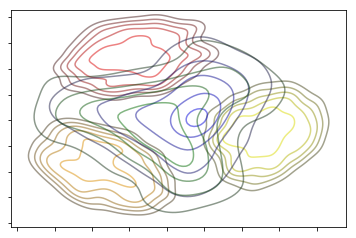

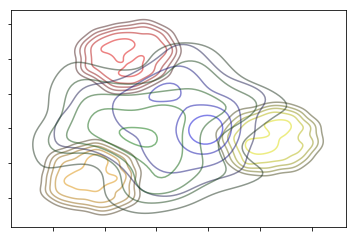

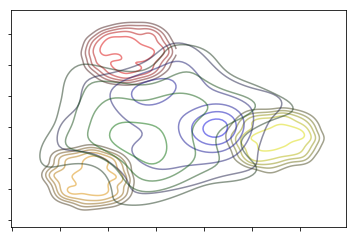

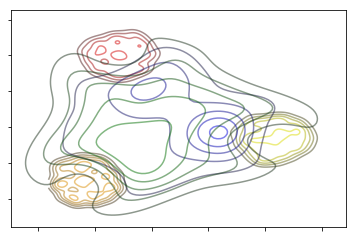

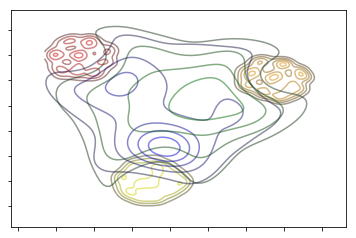

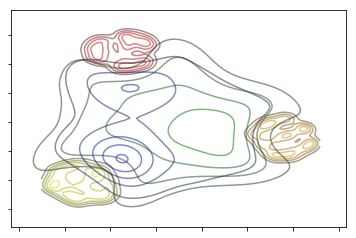

In [87]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter

num_classes = len(np.unique(y_agents))
labels = np.unique(y_agents)
y_sample = copy.deepcopy(y_agents)

# plot the 2D data points
labels.sort()
labels = list(reversed(labels))
print(labels)

for idx, perplexity in enumerate(perplexities):
    plot_dir = f'./plot-t-sne_per={perplexity}'

    fig = plt.figure()
    ax = fig.add_subplot(111)
    #colors = cm.Spectral(np.linspace(0, 1, num_classes))
    
    #s = np.linspace(2, 3, 10)
    #cmap = sns.cubehelix_palette(start=s[5], light=1, as_cmap=True)
    #colors = sns.cubehelix_palette(start=s[5], light=1, as_cmap=False)
    colors = ["red","yellow","orange", "blue", "green"]    
    
    xx = embeddings[idx][:, 0]
    yy = embeddings[idx][:, 1]
    
    for idx, label in enumerate(labels):
        xl = xx[y_sample==label]
        yl = yy[y_sample==label]
        #ax.scatter(xl, yl, color=colors[idx], label=label, s=10)
        sns.kdeplot(xl, yl, color=colors[idx], n_levels=5, shade=False, cut=1, ax=ax, alpha=0.5, cbar=False)


    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    #plt.legend(loc='best', scatterpoints=1, fontsize=10)
    plt.savefig(plot_dir+'-multi.pdf', format='pdf', dpi=1000)
    plt.savefig(plot_dir+'-multi.png', format='png', dpi=1000)
    plt.show()
    plt.close(fig)


['ScissorsAgent', 'RockAgent', 'PaperAgent', 'NaiveSP-ppo_h64_rnn', 'NaiveSP-ppo_h64_mlp']
['NaiveSP-ppo_h64_mlp', 'NaiveSP-ppo_h64_rnn']
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=5


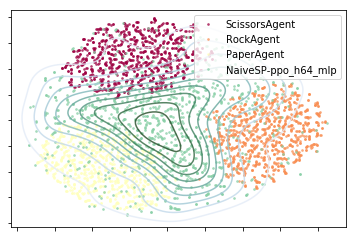

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=5
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=5


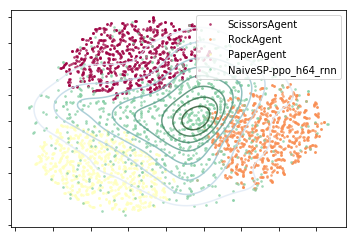

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=5
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=50


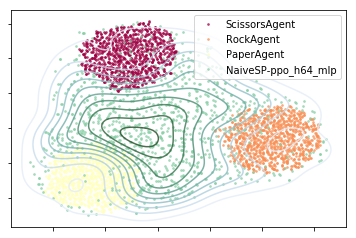

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=50
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=50


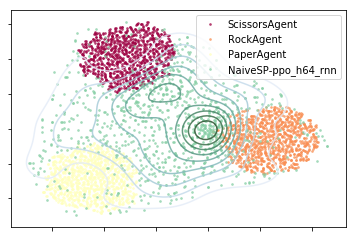

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=50
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=100


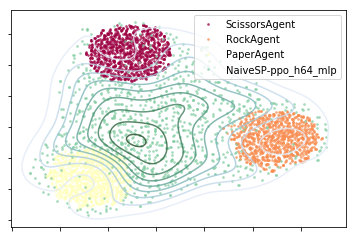

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=100
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=100


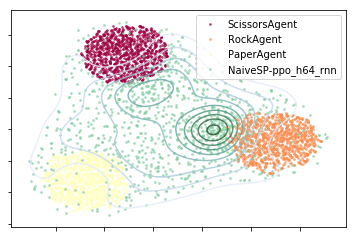

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=100
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=200


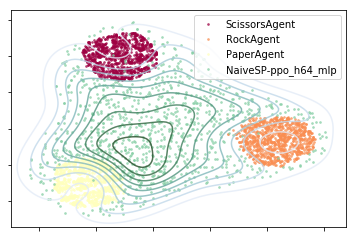

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=200
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=200


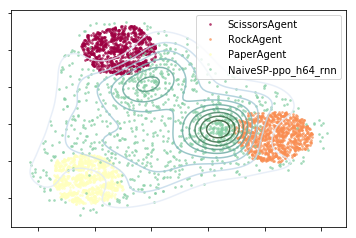

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=200
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=300


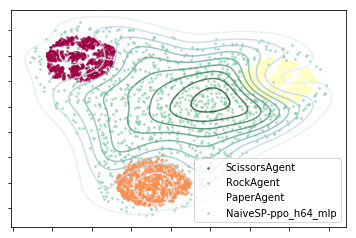

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=300
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=300


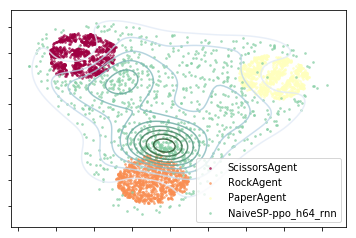

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=300
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=500


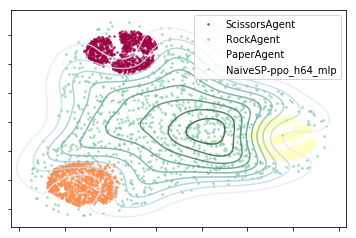

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=500
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=500


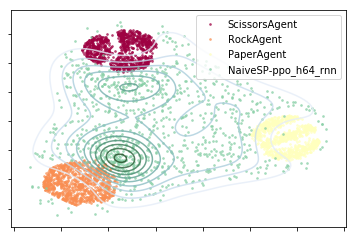

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=500


In [89]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter
import seaborn as sns

num_classes = len(np.unique(y_agents))
labels = np.unique(y_agents)
y_sample = copy.deepcopy(y_agents)

# plot the 2D data points
labels.sort()
labels = list(reversed(labels))
print(labels)
always_on_labels = [labels[0], labels[1], labels[2]]
#agent_labels = ['NaiveSP-ppo_h64_rnn']
agent_labels = list( set(labels) - set(always_on_labels) )
per_agent_labels_list = [ (agent_label, always_on_labels+[agent_label]) for agent_label in agent_labels]
print(agent_labels)

for idx, perplexity in enumerate(perplexities):
    for idx_label, pa_labels in enumerate(per_agent_labels_list):
        agent_label = pa_labels[0]
        pa_labels_list = pa_labels[1]
        plot_dir = f'./plot-t-sne_{agent_label}_per={perplexity}'

        xx = embeddings[idx][:, 0]
        yy = embeddings[idx][:, 1]
        
        # Create a cubehelix colormap to use with kdeplot
        s = np.linspace(0, 3, 10)[5]
        cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        colors = cm.Spectral(np.linspace(0, 1, num_classes))

        # Draw the background:
        xl = xx[y_sample==agent_label]
        yl = yy[y_sample==agent_label]
        sns.kdeplot(xl, yl, cmap=cmap, shade=False, cut=1, ax=ax, alpha=0.8)

        for idx_label, label in enumerate(pa_labels_list):
            xl = xx[y_sample==label]
            yl = yy[y_sample==label]
            ax.scatter(xl, yl, color=colors[idx_label], label=label, s=3, alpha=0.6)

        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        plt.legend(loc='best', scatterpoints=1, fontsize=10)
        plt.savefig(plot_dir+'.pdf', format='pdf', dpi=1000)
        plt.savefig(plot_dir+'.png', format='png', dpi=1000)
        print(plot_dir)
        plt.show()
        plt.close(fig)
        
        
        # SHADE ON :
        fig = plt.figure()
        ax = fig.add_subplot(111)
        colors = cm.Spectral(np.linspace(0, 1, num_classes))

        # Draw the background:
        xl = xx[y_sample==agent_label]
        yl = yy[y_sample==agent_label]
        sns.kdeplot(xl, yl, cmap=cmap, shade=True, cut=1, ax=ax, alpha=0.5, cbar=True)

        for idx_label, label in enumerate(pa_labels_list):
            xl = xx[y_sample==label]
            yl = yy[y_sample==label]
            ax.scatter(xl, yl, color=colors[idx_label], label=label, s=3, alpha=0.8)

        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        plt.legend(loc='best', scatterpoints=1, fontsize=10)
        plt.savefig(plot_dir+'_shaded.pdf', format='pdf', dpi=1000)
        plt.savefig(plot_dir+'_shaded.png', format='png', dpi=1000)
        print(plot_dir)
        #plt.show()
        plt.close(fig)


## Plot the average evolution of the menagerie through time:

In [117]:
import numpy as np
import matplotlib.pyplot as plt


def find_centroid(points):
    '''
    Finds centroid from set of points
    :param points: np.array of points
    '''
    length = points.shape[0]
    sum_x = np.sum(points[:, 0])
    sum_y = np.sum(points[:, 1])
    return np.array([sum_x/length, sum_y/length])


def divide_points(points, divisions):
    '''
    Divides :param: points into sub np.arrays
    :param points: np.array of points
    :param divisions: int, number of sub np.arrays we wish to divide the original :param: points
    '''
    return np.array_split(points, divisions)


def link_points(points, ax, colour_map):
    '''
    Plots :param: points as points linked by lines on :param: ax Axes.
    The colour of the points and the lines is a 'smooth' colour transition from
    both colour extremes of the :param: colour_map
    '''
    number_of_points = points.shape[0]
    colours = [colour_map(1.*i/(number_of_points-1)) for i in range(number_of_points-1)]
    point_pairs = zip(points, points[1:]) # Creates a pairs of points (p_0, p_1), (p_1, p_2)...
    for point_pair, colour in zip(point_pairs, colours):
        numpy_point_pair = np.array(point_pair)
        ax.plot(numpy_point_pair[:, 0], numpy_point_pair[:, 1], '-o', color=colour)


def plot_trajectory_evolution_in_embedded_space(points, divisions, ax, colour_map):
    divided_points = divide_points(points, divisions=divisions)
    centroids = np.array([find_centroid(sub_points) for sub_points in divided_points])
    link_points(centroids, ax, colour_map)

In [118]:
agent_sorted_training_df = sorted_training_df[ sorted_training_df.agent == agent_label]
points = list(agent_sorted_training_df[f'emb{idx}'].values)
points = [ list(p) for p in points]
print(type(points) )
print(type(points[0]))
points = np.asarray(points)
print(points.shape)


<class 'list'>
<class 'list'>
(1000, 2)


['ScissorsAgent', 'RockAgent', 'PaperAgent', 'NaiveSP-ppo_h64_rnn', 'NaiveSP-ppo_h64_mlp']
['NaiveSP-ppo_h64_mlp', 'NaiveSP-ppo_h64_rnn']
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=5_evolution_through_time


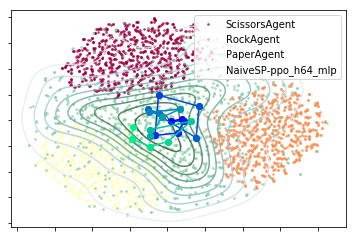

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=5_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=5_evolution_through_time


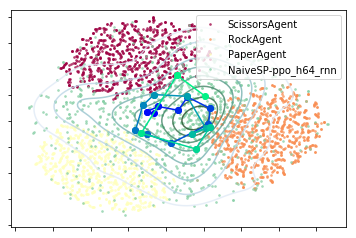

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=5_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=50_evolution_through_time


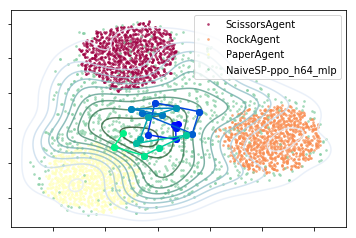

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=50_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=50_evolution_through_time


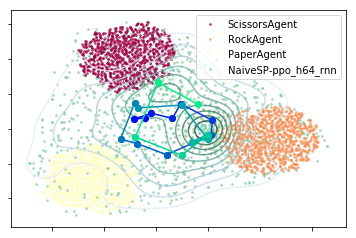

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=50_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=100_evolution_through_time


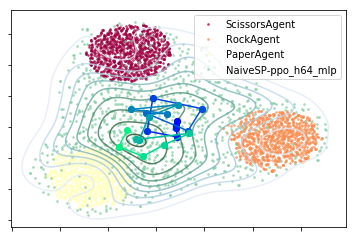

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=100_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=100_evolution_through_time


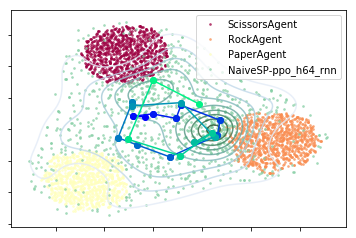

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=100_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=200_evolution_through_time


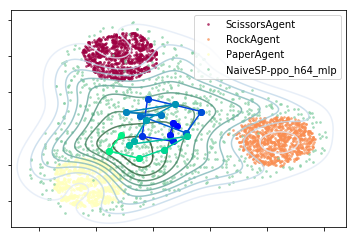

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=200_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=200_evolution_through_time


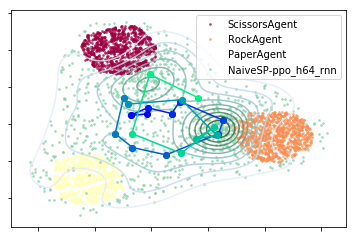

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=200_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=300_evolution_through_time


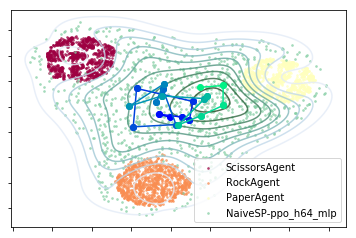

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=300_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=300_evolution_through_time


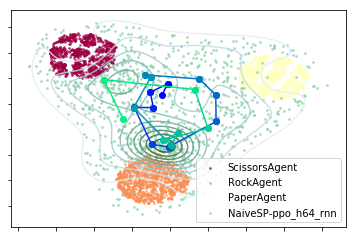

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=300_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_mlp_per=500_evolution_through_time


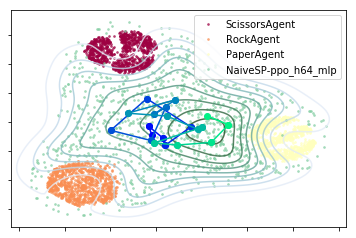

./plot-t-sne_NaiveSP-ppo_h64_mlp_per=500_evolution_through_time
./plot-t-sne_NaiveSP-ppo_h64_rnn_per=500_evolution_through_time


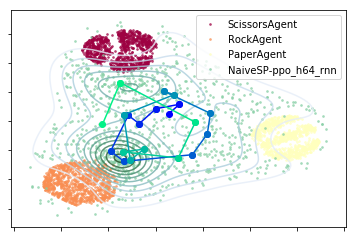

./plot-t-sne_NaiveSP-ppo_h64_rnn_per=500_evolution_through_time


In [120]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter
import seaborn as sns

num_classes = len(np.unique(y_agents))
labels = np.unique(y_agents)
y_sample = copy.deepcopy(y_agents)

# plot the 2D data points
labels.sort()
labels = list(reversed(labels))
print(labels)
always_on_labels = [labels[0], labels[1], labels[2]]
#agent_labels = ['NaiveSP-ppo_h64_rnn']
agent_labels = list( set(labels) - set(always_on_labels) )
per_agent_labels_list = [ (agent_label, always_on_labels+[agent_label]) for agent_label in agent_labels]
print(agent_labels)

for idx, perplexity in enumerate(perplexities):
    for idx_label, pa_labels in enumerate(per_agent_labels_list):
        agent_label = pa_labels[0]
        pa_labels_list = pa_labels[1]
        plot_dir = f'./plot-t-sne_{agent_label}_per={perplexity}_evolution_through_time'

        xx = embeddings[idx][:, 0]
        yy = embeddings[idx][:, 1]
        
        # Create a cubehelix colormap to use with kdeplot
        s = np.linspace(0, 3, 10)[5]
        cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
        colour_map = plt.get_cmap('winter')
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        colors = cm.Spectral(np.linspace(0, 1, num_classes))

        # Draw the background:
        xl = xx[y_sample==agent_label]
        yl = yy[y_sample==agent_label]
        sns.kdeplot(xl, yl, cmap=cmap, shade=False, cut=1, ax=ax, alpha=0.8)

        for idx_label, label in enumerate(pa_labels_list):
            xl = xx[y_sample==label]
            yl = yy[y_sample==label]
            ax.scatter(xl, yl, color=colors[idx_label], label=label, s=3, alpha=0.6)
        
        agent_sorted_training_df = sorted_training_df[ sorted_training_df.agent == agent_label]
        points = list(agent_sorted_training_df[f'emb{idx}'].values)
        points = [ list(p) for p in points]
        points = np.asarray(points)
        plot_trajectory_evolution_in_embedded_space(points, divisions=20, ax=ax, colour_map=colour_map)

        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        plt.legend(loc='best', scatterpoints=1, fontsize=10)
        plt.savefig(plot_dir+'.pdf', format='pdf', dpi=1000)
        plt.savefig(plot_dir+'.png', format='png', dpi=1000)
        print(plot_dir)
        plt.show()
        plt.close(fig)
        
        
        # SHADE ON :
        fig = plt.figure()
        ax = fig.add_subplot(111)
        colors = cm.Spectral(np.linspace(0, 1, num_classes))

        # Draw the background:
        xl = xx[y_sample==agent_label]
        yl = yy[y_sample==agent_label]
        sns.kdeplot(xl, yl, cmap=cmap, shade=True, cut=1, ax=ax, alpha=0.5, cbar=True)

        for idx_label, label in enumerate(pa_labels_list):
            xl = xx[y_sample==label]
            yl = yy[y_sample==label]
            ax.scatter(xl, yl, color=colors[idx_label], label=label, s=3, alpha=0.8)

        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
        plt.legend(loc='best', scatterpoints=1, fontsize=10)
        plt.savefig(plot_dir+'_shaded.pdf', format='pdf', dpi=1000)
        plt.savefig(plot_dir+'_shaded.png', format='png', dpi=1000)
        print(plot_dir)
        #plt.show()
        plt.close(fig)
